# Projet 2 - Analysez des données de systèmes éducatifs

## Table des matières
* [A - Analyse et reformulation de l'énoncé](#A)
* [B - Import et compréhension des données](#B)
    * [Description des données](#description)
* [C - Choix des indicateurs](#indicators)
* [D - Pré-filtrage des données](#prefilter)
    * [Suppression des autres indicateurs](#removing)
    * [Suppression des colonnes entièrement vides](#dropna)
    * [Suppression des pays trop petits](#small-countries)
    * [Suppression des années mal renseignées](#years)
    * [Taux de remplissage global de chaque indicateur](#fillings)
    * [Taux de remplissage par région géographique](#geofillings)
* [E - Regroupement des indicateurs](#grouping)
* [F - Second filtrage des données](#filtering)
    * [Suppression des pays trop pauvres](#poor-countries)
    * [Sélection du bon indicateur de population](#population)
    * [Remise au propre des données finales](#final-data)
* [G - Etude des indicateurs par région géographique](#geoanalysis)
* [H - Scoring des pays](#scoring)
    * [Classement des pays avec des coefficients égaux (référence)](#reference-ranking)
    * [Impact de la modification des pondérations - Méthode Borda](#borda)
* [I - Conclusion](#conclusion)

<a name="A"></a>
## A - Analyse et reformulation de l'énoncé
<ins>**Données issues de l'énoncé**</ins> : 
* Domaine de la **EdTech** pour Educational Technology (technologies de l'éducation).
* Academy est une **start-up** qui fournit des formation **en ligne** pour des niveaux **lycée et université**.
* Projet d'expansion à l'**international**.
* Les données sont fournies par la banque mondiale rubrique "[EdStats](https://datatopics.worldbank.org/education/)"

<ins>**Problématique**</ins> : analyser les [données](https://datacatalog.worldbank.org/dataset/education-statistics) de la banque mondiale afin de déterminer quels sont les pays avec les plus forts pontentiels **actuel et futur** d'expansion de Academy et déterminer **dans quels pays opérer en priorité**.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

plt.style.use('seaborn-whitegrid')

<a name="B"></a>
## B - Import et compréhension des données
### Import des données

In [2]:
# Data about countries
countries = pd.read_csv('data/EdStatsCountry.csv')

# Data about each indicator (unit, date, ...)
indicators = pd.read_csv('data/EdStatsSeries.csv')

# Data containing values of each indicators for each country and year
initial_data = pd.read_csv('data/EdStatsData.csv')
# Creating a copy to work on
data = initial_data.copy(deep=True)

# We load the 2 other files but we don't use them
series = pd.read_csv('data/EdStatsCountry-Series.csv', delimiter=',', doublequote=True)
footnotes = pd.read_csv('data/EdStatsFootNote.csv')

### Paramètres globaux
Cette section regroupe les paramètres qui influent directement sur la façon dont sont pré-filtrées et filtrées les données.

In [3]:
# Minimum population of the countries we keep in the dataset
MINIMUM_POPULATION = 2000000

# Maximum difference between the country revenue and the revenue of the reference country (France) - In percents (%)
MAX_REVENUE_PERCENT_DIFF = 20

# Minimum year to keep in the dataset (has been choosen by analysing the data below)
MIN_YEAR = 2005
MAX_YEAR = 2015

# Reference country code
REF_COUNTRY_CODE = "FRA"

<a name="description"></a>
### Description des données
Pour chacun des DataFrame ci-dessus j'utilise la méthode `.info()` qui nous permet de lister le nombre de lignes, le nombre de colonne, et pour chaque colonne, le nombre de valeur nulles.

In [4]:
def format_percentage(value):
    '''
    Format a percentage with 1 digit after comma 
    '''
    return "{0:.1f}%".format(value * 100)


# We create a table containing all information about the 5 files
files_description = pd.DataFrame(columns = ["Nb lignes", "Nb colonnes", "Taux remplissage moyen", "Doublons", "Description"],
                                 index = ["EdStatsCountry.csv", 
                                          "EdStatsSeries.csv", 
                                          "EdStatsData.csv", 
                                          "EdStatsCountry-Series.csv", 
                                          "EdStatsFootNote.csv"])

# Filling the total number rows in each file
files_description["Nb lignes"] = [
    len(countries.index),
    len(indicators.index),
    len(initial_data.index),
    len(series.index),
    len(footnotes.index)
]

# Filling the number of columns in each file
files_description["Nb colonnes"] = [
    len(countries.columns),
    len(indicators.columns),
    len(initial_data.columns),
    len(series.columns),
    len(footnotes.columns)
]

# Filling the fill-percentile of each file
# We use the mean() function twice to calculate the mean for each columns, and then the mean for the whole file
files_description["Taux remplissage moyen"] = [
    format_percentage(countries.notna().mean().mean()),
    format_percentage(indicators.notna().mean().mean()),
    format_percentage(initial_data.notna().mean().mean()),
    format_percentage(series.notna().mean().mean()),
    format_percentage(footnotes.notna().mean().mean())
]

# FIlling the number of duplicate keys for each file
files_description["Doublons"] = [
    countries.duplicated(subset=["Country Code"]).sum(),
    indicators.duplicated(subset=["Indicator Name"]).sum(),
    initial_data.duplicated(subset=["Country Code", "Indicator Name"]).sum(),
    series.duplicated(subset=["CountryCode", "SeriesCode"]).sum(),
    footnotes.duplicated(subset=["CountryCode", "SeriesCode", "Year"]).sum(),
]

# Finally adding a short description for each file
files_description["Description"] = [
    "Liste des pays avec leurs données principales",
    "Liste des indicateurs avec description, unité, période, etc...",
    "Données de chaque indicateur par pays et par année",
    "Description des différentes séries de données (majoritairement provenance)",
    "Commentaire pour chaque couple série de données / pays"
]


files_description

Nb lignes  Nb colonnes Taux remplissage moyen  \
EdStatsCountry.csv               241           32                  69.5%   
EdStatsSeries.csv               3665           21                  28.3%   
EdStatsData.csv               886930           70                  13.9%   
EdStatsCountry-Series.csv        613            4                  75.0%   
EdStatsFootNote.csv           643638            5                  80.0%   

                           Doublons  \
EdStatsCountry.csv                0   
EdStatsSeries.csv                 0   
EdStatsData.csv                   0   
EdStatsCountry-Series.csv         0   
EdStatsFootNote.csv               0   

                                                                 Description  
EdStatsCountry.csv             Liste des pays avec leurs données principales  
EdStatsSeries.csv          Liste des indicateurs avec description, unité,...  
EdStatsData.csv            Données de chaque indicateur par pays et par a...  
EdStatsCountry-Series.csv  Description des différentes séries de données ...  
EdStatsFootNote.csv        Commentaire pour chaque couple série de donnée...

<a name="indicators"></a>
## C - Choix des indicateurs
L'idée est maintenant de trouver les indicateurs qui nous intéressent parmi les 3665 proposés. Pour répondre à notre problématique, on va tout d'abord se focaliser sur les idées suivantes : 
* Définir la **quantité d'étudiants** par pays en se basant, par exemple, sur la population par tranche d'âge.
* Définir l'**accès à internet**  : accès des étudiants à un ordinateur et une connexion internet correcte.
* Définir le **revenu moyen** du pays afin de savoir si les étudiants auront de quoi payer les cours en ligne.
* Définir la **langue principale du pays** : le français et l'anglais étant plus facile à traduire.

J'utilise la [liste des indicateurs](http://datatopics.worldbank.org/education/) afin de les trouver plus facilement.


In [5]:
# Preparing a list that will contains all the indicator codes we want to keep
choosen_indicators = []

### Population étudiante
Plusieurs indicateurs peuvent nous aider à cibler la population qui nous intéresse, sachant que l'on cherche à chiffrer l'effectif de la population lycée/université, soit environ la tranche d'âge 15-25 ans.
* **SP.POP.TOTL** : population totale à la mi-année décomposée en **SP.POP.TOTL.FE.IN** (femmes) et **SP.POP.TOTL.MA.IN** (hommes)
* **SP.POP.GROW** : taux de croissance de la population -> utile pour les projections futures
* **SP.POP.1524.TO.UN** : population totale de la tranche 15-24 ans
* **SP.SEC.TOTL.IN** : population totale ayant l'âge d'entrer en éducation secondaire (secondary ed.)
* **SP.SEC.UTOT.IN** : population totale ayant l'âge d'entrer en éducation secondaire élevée (upper secondary ed.)
* **SP.TER.TOTL.IN** : population totale ayant l'âge d'entrer en éducation tertiaire (tertiary ed.)

On va **tous les conserver dans un premier temps** et on analysera ensuite lequel (ou lesquels) sont les plus pertinents et les plus fiables pour notre utilisation (voir [plus bas dans le fichier](#population)).

In [6]:
population_indicators = ["SP.POP.TOTL", "SP.POP.GROW", "SP.POP.1524.TO.UN", "SP.SEC.TOTL.IN", "SP.SEC.UTOT.IN", 
                         "SP.TER.TOTL.IN"]

### Accès à internet
En terme de communication, deux indicateurs nous indiquent le pourcentage d'ordinateurs personnels et de connexion internet pour 100 habitants :

* **IT.NET.USER.P2** : pourcentage d'utilisateurs d'internet
* **IT.CMP.PCMP.P2** : pourcentage de possesseur d'un ordinateur personnel

J'ai également recherché des indicateurs concernant les **compétences informatique** mais si plusieurs sont indiqués dans la documentation de la banque mondiale, aucun n'est présent dans le dataset.

In [7]:
internet_indicators = ["IT.NET.USER.P2", "IT.CMP.PCMP.P2"]

### Revenu moyen du pays
Même si cet indicateur sera probablement fortement lié à l'accès à un ordinateur personnel, il nous permettra de savoir si la population a, ou non, sensiblement le même pouvoir d'achat que notre pays de référence.

Le dataset nous donne accès au **PNB par habitant** ainsi qu'au **PIB par habitant**. Ce dernier est le plus représentatif du niveau de vie moyen du pays, surtout qu'il est ici exprimé en "Parité de Pouvoir d'Achat" (**PPA** ou en anglais PPP) ce qui signifie qu'on tient compte du coût de la vie dans le pays. Cela permet d'avoir une comparaison plus fiable entre les pays.
* **NY.GDP.MKTP.PP.CD** :  PIB (PPP - Current US Dollar)
* **NY.GDP.PCAP.PP.CD** : PIB par habitant (PPP - Current US Dollar)

Pour nous, cet indicateur sera **obligatoire** : on supprimera du dataset tous les pays pour lesquels il n'est pas renseigné.

In [8]:
revenue_indicators = ["NY.GDP.PCAP.PP.CD"]

### Langue principale
Après étude détaillée des indicateurs, aucun ne semble actuellement nous renseigner sur la langue principale parlée dans le pays. C'est éventuellement une donnée que nous pourrons intégrer à posteriori pour départager 2 pays très proches en termes de score.

### Récapitulatif des indicateurs

In [9]:
choosen_indicators.extend(population_indicators)
choosen_indicators.extend(internet_indicators)
choosen_indicators.extend(revenue_indicators)
choosen_indicators

['SP.POP.TOTL',
 'SP.POP.GROW',
 'SP.POP.1524.TO.UN',
 'SP.SEC.TOTL.IN',
 'SP.SEC.UTOT.IN',
 'SP.TER.TOTL.IN',
 'IT.NET.USER.P2',
 'IT.CMP.PCMP.P2',
 'NY.GDP.PCAP.PP.CD']

<a name="prefilter"></a>
## D - Pré-filtrage des données
Le pré-filtrage effectué ici est une succession d'opération de filtrages facile à appliquer. Le but est de venir amputer le Dataset d'un grand nombre de lignes afin de faciliter les opérations de filtrages plus minutieuses à venir ensuite.
<a name="removing"></a>
### Suppression des indicateurs non retenus
On ne conserve maintenant que les lignes des indicateurs qui nous intéressent et on supprime également les colonnes non utiles tel que les noms de pays et les noms des indicateurs.

In [10]:
# Filtering the data set on the selected indicators
data = data[data["Indicator Code"].isin(choosen_indicators)]

# Displaying a warning if one choosen indicator is not in the dataset
if len(choosen_indicators) > len(data["Indicator Code"].unique()):
    print("ATTENTION : certains indicateurs n'ont pas été trouvé dans le tableau de données")
    
# Also removing columns that are not useful for the moment (we keep the keys columns)
data = data.drop(["Country Name", "Indicator Name"], axis=1, errors="ignore")

data

Country Code     Indicator Code          1970          1971  \
1247            ARB  NY.GDP.PCAP.PP.CD           NaN           NaN   
1375            ARB     IT.NET.USER.P2           NaN           NaN   
2084            ARB     IT.CMP.PCMP.P2           NaN           NaN   
2307            ARB        SP.POP.GROW  2.767219e+00  2.694623e+00   
2323            ARB     SP.SEC.TOTL.IN  1.887675e+07  1.947298e+07   
...             ...                ...           ...           ...   
885588          ZWE     SP.SEC.TOTL.IN  6.752820e+05  7.046000e+05   
885591          ZWE     SP.TER.TOTL.IN  3.780360e+05  4.002460e+05   
885597          ZWE     SP.SEC.UTOT.IN  4.302470e+05  4.526340e+05   
885747          ZWE  SP.POP.1524.TO.UN           NaN           NaN   
885798          ZWE        SP.POP.TOTL  5.175618e+06  5.351195e+06   

                1972          1973          1974          1975          1976  \
1247             NaN           NaN           NaN           NaN           NaN   
1375             NaN           NaN           NaN           NaN           NaN   
2084             NaN           NaN           NaN           NaN           NaN   
2307    2.658899e+00  2.687857e+00  2.795847e+00  2.948191e+00  3.106885e+00   
2323    1.994125e+07  2.042827e+07  2.096031e+07  2.155374e+07  2.219776e+07   
...              ...           ...           ...           ...           ...   
885588  7.299310e+05  7.534980e+05  7.784100e+05  8.060640e+05  8.324490e+05   
885591  4.320310e+05  4.691810e+05  5.049590e+05  5.352320e+05  5.574990e+05   
885597  4.701910e+05  4.845080e+05  4.986040e+05  5.148170e+05  5.304850e+05   
885747           NaN           NaN           NaN           NaN           NaN   
885798  5.535874e+06  5.727044e+06  5.920943e+06  6.115370e+06  6.308300e+06   

                1977  ...  2060  2065  2070  2075  2080  2085  2090  2095  \
1247             NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1375             NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2084             NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2307    3.228207e+00  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2323    2.261543e+07  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...              ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
885588  8.616450e+05  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
885591  5.749350e+05  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
885597  5.487370e+05  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
885747           NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
885798  6.501893e+06  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

        2100  Unnamed: 69  
1247     NaN          NaN  
1375     NaN          NaN  
2084     NaN          NaN  
2307     NaN          NaN  
2323     NaN          NaN  
...      ...          ...  
885588   NaN          NaN  
885591   NaN          NaN  
885597   NaN          NaN  
885747   NaN          NaN  
885798   NaN          NaN  

[2178 rows x 68 columns]

<a name="dropna"></a>
### Suppression des colonnes entièrement vides

In [11]:
data.dropna(axis=1, how="all", inplace=True)

<a name="small-countries"></a>
### Suppression des pays trop petits
Afin de faciliter le travail d'analyse à venir et réduire significativement le nombre de ligne, nous allons commencer par éliminer les pays à la population trop faible.

**Rappel** : la population minimale retenue ici est indiquée en début de Notebook au niveau des paramètres.

In [12]:
# Step 0 - Retrieving the population data from the main dataset
countries_populations = data[data["Indicator Code"] == "SP.POP.TOTL"]

# Step 1 - Removing columns where all values are NaN
countries_populations.reset_index(inplace=True)
countries_populations.set_index("Country Code", inplace=True)

# Step 2 - Calculating the mean population for each country
countries_populations = countries_populations.mean(axis=1).to_frame()
countries_populations.columns = ["Population"]

# Step 3 - Keeping countries codes
biggest_countries_codes = countries_populations[countries_populations["Population"] >= MINIMUM_POPULATION].index.values

# Finally filtering data
data = data[data["Country Code"].isin(biggest_countries_codes)]

<a name="years"></a>
### Suppression des années trop anciennes et mal renseignées
On va maintenant analyser le taux de remplissage des données de nos indicateurs retenus, par année, ce qui nous permettra d'en supprimer une partie.

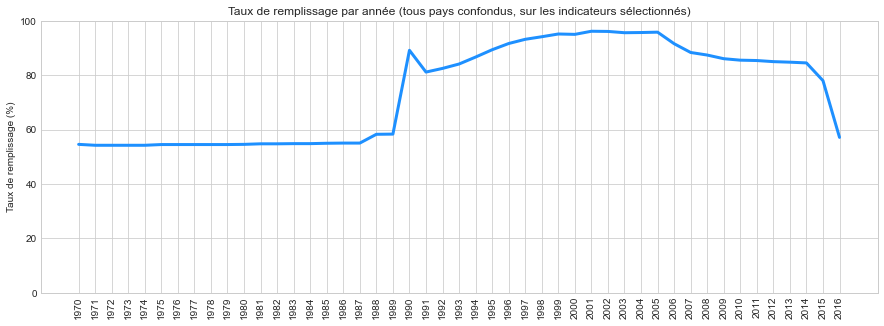

In [13]:
# For the next filterings, want to know the global "filling percentage" of all selected indicators merged
year_filling = data.drop(columns=["Country Code", "Indicator Code"]).notnull().sum(axis=0).to_frame()

# We calculate it as a percentile (max possible values per year = nb of countries * nb of indicators)
max_values = len(choosen_indicators) * len(data["Country Code"].unique())
year_filling = 100 * year_filling / max_values

fig1 = plt.figure(figsize=(15,5))
plt.title("Taux de remplissage par année (tous pays confondus, sur les indicateurs sélectionnés)")
plt.xticks(rotation = 90)
plt.ylim(ymin=0, ymax=100)
plt.ylabel("Taux de remplissage (%)")
plt.plot(year_filling.index.values, year_filling[0], color="dodgerblue", linewidth=3)

On constate plusieurs choses : 
* Les années **après 2016** avaient déjà été supprimées, ce qui signifie qu'elles étaient vides pour nos indicateurs. ON va toutefois exclure en plus l'année 2016 qui est significativement moins renseignée que 2015.
* Les années **avant 1990** sont moins remplies, et nous intéressent peu car internet n'est apparu qu'en 1991.

De plus, au vu de l'évolution rapide des nouvelles technologies, **il parait peut pertinent de conserver les années antérieures à 2005** (apparition de Youtube, Facebook, essor des réseaux sociaux et des plateformes de streaming) car elles sont peu représentatives des nouvelles technologies, et risqueraient ainsi de faire chuter nos indicateurs "technologiques" (accès internet et accès à des ordinateurs).

**CONCLUSION** : on ne conserve que **les années après 2005 (inclue) et avant 2016 (exclue)**.

Ces 2 années sont mises en paramètre en début de Notebook.

In [14]:
# The MIN_YEAR variable has been defined at the beginning of the notebook

# We save the data before filtering it because we need it below
data_before_year_filtering = data.copy(deep=True)

# Isolating the columns we want to drop from the DF
years = list(filter(lambda x: re.match("^\d{4}$", x), data.columns.values))
dropped_years = [year for year in years if int(year) < MIN_YEAR or int(year) > MAX_YEAR]

# Finally removing the unwanted values
data = data.drop(columns=dropped_years)

data

Country Code     Indicator Code          2005          2006  \
1247            ARB  NY.GDP.PCAP.PP.CD  1.140472e+04  1.228111e+04   
1375            ARB     IT.NET.USER.P2  8.393142e+00  1.165465e+01   
2084            ARB     IT.CMP.PCMP.P2  5.305007e+00  6.676681e+00   
2307            ARB        SP.POP.GROW  2.311472e+00  2.356627e+00   
2323            ARB     SP.SEC.TOTL.IN  4.262789e+07  4.298773e+07   
...             ...                ...           ...           ...   
885588          ZWE     SP.SEC.TOTL.IN  2.034066e+06  2.026737e+06   
885591          ZWE     SP.TER.TOTL.IN  1.542683e+06  1.554849e+06   
885597          ZWE     SP.SEC.UTOT.IN  1.344484e+06  1.341028e+06   
885747          ZWE  SP.POP.1524.TO.UN  3.266903e+06  3.309907e+06   
885798          ZWE        SP.POP.TOTL  1.294003e+07  1.312427e+07   

                2007          2008          2009          2010          2011  \
1247    1.300436e+04  1.373891e+04  1.385056e+04  1.444467e+04  1.482591e+04   
1375    1.420590e+01  1.859353e+01  2.297369e+01  2.674725e+01  2.970776e+01   
2084             NaN           NaN           NaN           NaN           NaN   
2307    2.386344e+00  2.381136e+00  2.323576e+00  2.230786e+00  2.128048e+00   
2323    4.404203e+07  4.428236e+07  4.425107e+07  4.428212e+07  4.427659e+07   
...              ...           ...           ...           ...           ...   
885588  2.020780e+06  2.016726e+06  2.015706e+06  2.018022e+06  2.009047e+06   
885591  1.565455e+06  1.576742e+06  1.589291e+06  1.602057e+06  1.601799e+06   
885597  1.338730e+06  1.337559e+06  1.337565e+06  1.338788e+06  1.331526e+06   
885747  3.342927e+06  3.366486e+06  3.381553e+06  3.389035e+06  3.389423e+06   
885798  1.332991e+07  1.355847e+07  1.381060e+07  1.408632e+07  1.438665e+07   

                2012          2013        2014        2015  
1247    1.571614e+04  1.605255e+04         NaN         NaN  
1375    3.401422e+01  3.686860e+01         NaN         NaN  
2084             NaN           NaN         NaN         NaN  
2307    2.063874e+00  2.012570e+00         NaN         NaN  
2323    4.435677e+07  4.446921e+07  43786276.0         NaN  
...              ...           ...         ...         ...  
885588  2.007007e+06  2.012733e+06   2026425.0   2047619.0  
885591  1.601931e+06  1.602843e+06   1604698.0   1607620.0  
885597  1.327364e+06  1.327040e+06   1331677.0   1342035.0  
885747  3.383141e+06  3.371070e+06   3354236.0   3333716.0  
885798  1.471083e+07  1.505451e+07  15411675.0  15777451.0  

[1485 rows x 13 columns]

<a name="fillings"></a>
### Taux de remplissage global de chaque indicateur
On vérifie maintenant les taux de remplissage de nos indicateurs sur les années sélectionnées.

<BarContainer object of 9 artists>

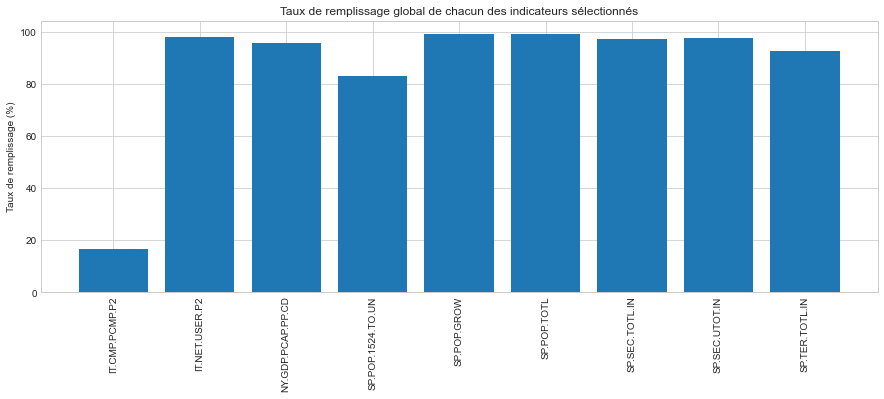

In [15]:
# We count how many values (non NaN) we have for each indicator and we devide it by the number of countries
indicator_filling = (data
                     .drop(columns=["Country Code"])
                     .set_index("Indicator Code")
                     .notnull()
                     .groupby("Indicator Code")
                     .sum())
indicator_filling = 100 * indicator_filling / len(data["Country Code"].unique())

# Plotting the result
fig2 = plt.figure(figsize=(15,5))
plt.title("Taux de remplissage global de chacun des indicateurs sélectionnés")
plt.xticks(rotation = 90)
plt.ylabel("Taux de remplissage (%)")
plt.bar(indicator_filling.index.values, indicator_filling.mean(axis=1))

On constate que tous les indicateurs sont **très bien renseignés** à l'exception de "**IT.CMP.PCMP.P2**".

Cet indicateur est à 0% de remplissage sur les années sélectionnées, ce qui est gênant car c'est un indicateur primordial pour la suite de notre étude. 

Nous allons voir à quel point il est rempli dans les autres années.

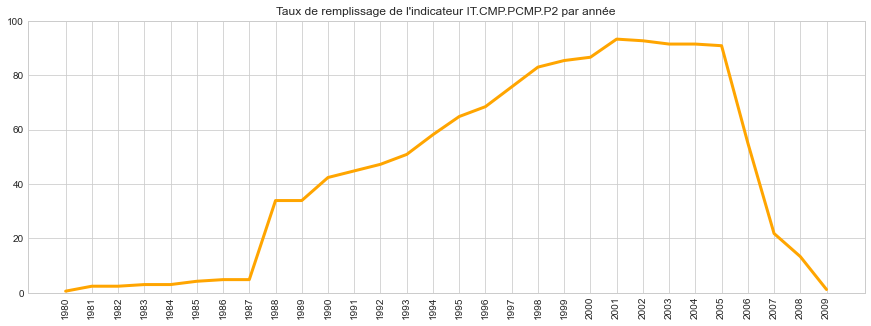

In [16]:
# We calculate the filling percentage of the given indicator for each year > 0
pcmp_filling = data_before_year_filtering[data_before_year_filtering["Indicator Code"] == "IT.CMP.PCMP.P2"]
pcmp_filling = (pcmp_filling
                .drop(columns=["Country Code"])
                .set_index("Indicator Code")
                .notnull()
                .groupby("Indicator Code")
                .sum())
pcmp_filling = pcmp_filling / len(data_before_year_filtering["Country Code"].unique())
pcmp_filling = pcmp_filling.loc[:, (pcmp_filling != 0).any(axis=0)]

# We plot the results
fig3 = plt.figure(figsize=(15,5))
plt.title("Taux de remplissage de l'indicateur IT.CMP.PCMP.P2 par année")
plt.xticks(rotation = 90)
plt.ylim(ymin=0, ymax=100)
plt.plot(pcmp_filling.columns.values, 100 * pcmp_filling.loc["IT.CMP.PCMP.P2"], color="orange", linewidth=3)

**CONCLUSION** : pour cet indicateur-là, nous allons prendre une moyenne sur les années **2001-2005**.

<a name="geofillings"></a>
### Taux de remplissage par région géographique
On veut maintenant regarder si les indicateurs sont mieux remplis dans certaines portions du monde, ce qui nous permettrait d'éliminer certains continent si les indicateurs y sont très mal renseignés.

Pour cela, on utilise la colonne "Region" du fichier des pays ; et on calcul un pourcentage au prorata du nombre de pays dans chaque continent (pour éviter d'avoir, par exemple, l'Amérique du Noed avec un score faible, du fait qu'elle ne contient que 2 pays).

                            2005  2006  2007  2008  2009  2010  2011  2012  \
Region                                                                       
East Asia & Pacific          154   151   145   142   141   140   139   138   
Europe & Central Asia        360   351   337   332   325   322   321   322   
Latin America & Caribbean    195   177   179   178   174   171   174   174   
Middle East & North Africa   138   136   131   129   124   123   122   120   
North America                 18    18    16    16    16    16    16    16   
South Asia                    53    51    49    48    48    48    48    47   
Sub-Saharan Africa           306   284   280   279   276   276   274   271   

                            2013  2014  2015  
Region                                        
East Asia & Pacific          137   139   135  
Europe & Central Asia        322   323   314  
Latin America & Caribbean    174   173   172  
Middle East & North Africa   120   123   121  
North America  

<BarContainer object of 7 artists>

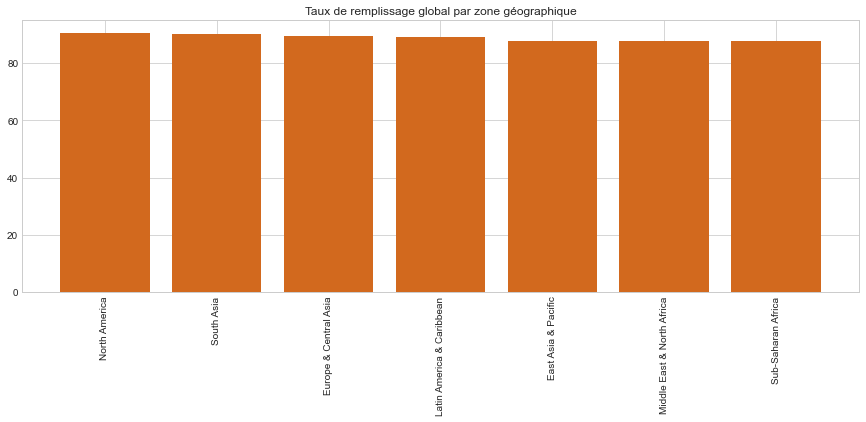

In [17]:
# Step 1 - We isolate country code and region from country file and kipping only on our selected countries
regions = (countries[countries["Country Code"].isin(biggest_countries_codes)]
           .set_index("Country Code")
           .filter(items=["Region"]))

# Step 2 - We also calculate how many countries we have per region in order to calculate our percentile 
country_per_region = (regions
                      .reset_index()
                      .set_index("Region")
                      .notnull()
                      .groupby("Region")
                      .sum())
country_per_region.columns = ["Total countries"]

# Step 3 - We count how many indicators are filled for each Region
geographical_data = data.copy(deep=True)
geographical_data = (geographical_data
                     .merge(regions, how="left", on="Country Code")
                     .drop(columns=["Country Code", "Indicator Code"])
                     .dropna(axis=0, how="any", subset=["Region"])
                     .set_index("Region")
                     .notnull()
                     .groupby("Region")
                     .sum())
nb_of_years = len(geographical_data.columns)
print(geographical_data)
geographical_data = geographical_data.sum(axis=1).to_frame().astype("float")


# Step 4 - We divide the number of filled indicators by the number of theoretical indicators per region
for region, total in geographical_data.itertuples():
    region_max = country_per_region.loc[region]["Total countries"] * nb_of_years * len(choosen_indicators)
    geographical_data.loc[region][0] = geographical_data.loc[region][0] / region_max

# Step 5 - We sort the results to improve chart readability
geographical_data.sort_values(by=[0], axis=0, ascending=False, inplace=True)

# We plot the results
fig4 = plt.figure(figsize=(15,5))
plt.title("Taux de remplissage global par zone géographique")
plt.xticks(rotation = 90)
plt.bar(geographical_data.index.values, 100 * geographical_data[0], color="chocolate")

**CONCLUSION** : pour les indicateurs sélectionnés, on ne note pas de disparité particulière en terme de remplissage. **Toutes les zones géographiques peuvent donc être analysées.**

<a name="grouping"></a>
## E - Regroupement des indicateurs
Le but de cette partie est de créer un tableau qui contient une ligne par pays, et une colonne par indicateur avec la valeur finale conservée pour celui-ci. On va traiter séparément notre indicateur **IT.CMP.PCMP.P2** qui n'a pas de valeur pour les années sélectionnées.

In [18]:
# We create a table with the mean value of each indicator for each country
final_indicators_values = (
                           (data[data["Indicator Code"].isin(choosen_indicators)]
                            .groupby(["Country Code", "Indicator Code"])
                            .mean()
                           )
                           .mean(axis=1)
                           .to_frame()
                           .unstack(level=1)
                           .droplevel(0, axis=1)
                           .drop(columns=["IT.CMP.PCMP.P2"]))

# Now we have to fill the IT.CMP.PCMP.P2 indicator with the 2011-2005 years
pcmp_data = initial_data.copy(deep=True)
kept_years = ["2001", "2002", "2003", "2004", "2005"]
pcmp_data = (pcmp_data[(pcmp_data["Indicator Code"] == "IT.CMP.PCMP.P2") 
                       & (pcmp_data["Country Code"].isin(biggest_countries_codes))]
             .drop(columns=["Country Name", "Indicator Name", "Indicator Code"])
             .set_index("Country Code")
             .filter(items=kept_years)
             .mean(axis=1)
             .to_frame())
pcmp_data.columns = ["IT.CMP.PCMP.P2"]

# And we merge it with the previous dataframe
final_indicators_values = final_indicators_values.merge(pcmp_data, how="left", left_index=True, right_index=True)

final_indicators_values

IT.NET.USER.P2  NY.GDP.PCAP.PP.CD  SP.POP.1524.TO.UN  \
Country Code                                                         
AFG                 4.203256        1522.744280       6.086033e+06   
AGO                 4.767579        5615.334689       3.759384e+06   
ALB                38.632626        9151.101768       5.922224e+05   
ARB                22.573194       13924.325331                NaN   
ARE                70.899999       67696.458346       6.966785e+05   
...                      ...                ...                ...   
WLD                28.811730       13019.761900                NaN   
YEM                12.317576        3865.832112       5.322463e+06   
ZAF                26.180016       11885.731155       9.791719e+06   
ZMB                10.373624        3133.583626       2.731424e+06   
ZWE                 8.791596        1626.424289       3.353491e+06   

              SP.POP.GROW   SP.POP.TOTL  SP.SEC.TOTL.IN  SP.SEC.UTOT.IN  \
Country Code                                                              
AFG              3.050737  2.911948e+07    3.951402e+06    1.851418e+06   
AGO              3.543825  2.350760e+07    3.086217e+06    1.409631e+06   
ALB             -0.450159  2.930218e+06    4.242545e+05    2.027324e+05   
ARB              2.243826  3.399244e+08    4.393621e+07    2.143393e+07   
ARE              7.328954  7.591034e+06    4.965165e+05    2.363435e+05   
...                   ...           ...             ...             ...   
WLD              1.220566  6.932254e+09    7.735857e+08    3.908681e+08   
YEM              2.692212  2.366675e+07    3.527940e+06    1.719501e+06   
ZAF              1.430610  5.111124e+07    5.242876e+06    3.152177e+06   
ZMB              2.877793  1.394455e+07    1.586452e+06    9.222738e+05   
ZWE              1.917228  1.419915e+07    2.021352e+06    1.336163e+06   

              SP.TER.TOTL.IN  IT.CMP.PCMP.P2  
Country Code                                  
AFG             2.617563e+06        0.341903  
AGO             1.999056e+06        0.288022  
ALB             2.770651e+05        1.298910  
ARB             3.434931e+07        3.523555  
ARE             3.818900e+05       19.040030  
...                      ...             ...  
WLD             6.032868e+08        9.487885  
YEM             2.518379e+06        1.110148  
ZAF             5.215752e+06        7.507682  
ZMB             1.341998e+06        0.900405  
ZWE             1.586361e+06        4.685976  

[165 rows x 9 columns]

<a name="filtering"></a>
## F - Second filtrage des données
<a name="poor-countries"></a>
### Suppression des pays trop pauvres
Nous allons à présent enlever du dataset les pays dont le PIB est trop inférieur à celui **de la France** qui est notre pays de référence.

Nous pouvons nous appuyer sur le **PNB par habitant PPA** car nous avons vérifé (lors de l'étape suivante) que c'était un indicateur fiable dans notre set d'années et de pays.

In [19]:
# At first we calculate the mean GDP PPP of our reference country (France)
fra_gdp_ppp = (data[(data["Country Code"] == "FRA") & (data["Indicator Code"] == "NY.GDP.PCAP.PP.CD")]
               .drop(columns=["Country Code", "Indicator Code"])
               .mean(axis=1)
               .values[0])

# Now we calculate the min GDP PPP we want 
min_gdp_ppp = fra_gdp_ppp * (1 - (MAX_REVENUE_PERCENT_DIFF / 100))

final_indicators_values = final_indicators_values[final_indicators_values["NY.GDP.PCAP.PP.CD"] >= min_gdp_ppp]

print("Après filtrage par PIB, il reste " + str(len(final_indicators_values)) + " pays.")
final_indicators_values

Après filtrage par PIB, il reste 32 pays.


IT.NET.USER.P2  NY.GDP.PCAP.PP.CD  SP.POP.1524.TO.UN  \
Country Code                                                         
ARE                70.899999       67696.458346       6.966785e+05   
AUS                75.533792       40319.447119       2.893898e+06   
AUT                74.253159       43121.353596       9.985681e+05   
BEL                73.230281       39945.278170       1.257487e+06   
CAN                80.177273       40888.846541       4.436876e+06   
CHE                81.728371       53839.470734       9.425225e+05   
DEU                79.690891       40353.950827       9.329035e+06   
DNK                89.456384       42543.280718       6.623500e+05   
EMU                68.015795       36290.212686                NaN   
ESP                64.052236       32197.603080       4.677938e+06   
EUU                65.400379       32541.155608                NaN   
FIN                84.638811       38828.483565       6.519545e+05   
FRA                71.363118       36294.355035       7.655038e+06   
GBR                82.470400       36892.208753       7.935112e+06   
HIC                71.115527       40056.949801                NaN   
HKG                70.428602       47540.573049       8.846617e+05   
IRL                68.184399       47451.725492       6.036924e+05   
ISR                59.409747       29956.162228       1.133022e+06   
ITA                49.389045       34893.660928       5.811026e+06   
JPN                78.950104       35832.512013       1.285234e+07   
KOR                82.409507       29926.802618       6.667012e+06   
NAC                72.807985       48906.216882                NaN   
NLD                89.083381       45124.941233       1.988785e+06   
NOR                91.255787       59599.063347       6.186391e+05   
NZL                77.549779       31970.523981       6.138339e+05   
OED                65.147673       34586.218874                NaN   
OMN                38.644992       42071.652237       5.666412e+05   
PRI                49.373188       34179.042553                NaN   
SAU                43.044953       46759.803340       4.894137e+06   
SGP                70.985841       70909.129321       6.388882e+05   
SWE                89.951252       42161.955087       1.182212e+06   
USA                71.997537       49788.978295       4.462605e+07   

              SP.POP.GROW   SP.POP.TOTL  SP.SEC.TOTL.IN  SP.SEC.UTOT.IN  \
Country Code                                                              
ARE              7.328954  7.591034e+06    4.965165e+05    2.363435e+05   
AUS              1.519595  2.202987e+07    1.723876e+06    5.868987e+05   
AUT              0.499110  8.390539e+06    7.453200e+05    3.861671e+05   
BEL              0.715277  1.089967e+07    7.523212e+05    5.060148e+05   
CAN              1.033865  3.402655e+07    2.524405e+06    1.574099e+06   
CHE              1.036866  7.832566e+06    6.209898e+05    3.611246e+05   
DEU             -0.091866  8.153792e+07    7.436282e+06    2.631099e+06   
DNK              0.457528  5.544234e+06    4.124765e+05    2.050826e+05   
EMU              0.323312  3.350522e+08    2.612996e+07    1.193730e+07   
ESP              0.717680  4.593051e+07    2.571650e+06    9.890645e+05   
EUU              0.275956  5.025433e+08    4.040106e+07    1.978306e+07   
FIN              0.426889  5.363542e+06    3.859530e+05    1.957276e+05   
FRA              0.551149  6.498942e+07    5.327524e+06    2.288691e+06   
GBR              0.747498  6.274996e+07    5.349736e+06    3.133256e+06   
HIC              0.666860  1.146985e+09    8.835193e+07    4.429316e+07   
HKG              0.674197  7.045682e+06    5.347871e+05    3.066569e+05   
IRL              1.262857  4.497597e+06    2.765014e+05    1.114500e+05   
ISR              1.887405  7.628500e+06    6.983893e+05    3.417004e+05   
ITA              0.467678  5.931128e+07    4.528174e+06    2.854811e+06   
JPN             -0.044224  1.277393e+08    7.258621e+06   

<a name="population"></a>
### Sélection du bon indicateur de population
Il nous reste à présent à choisir l'indicateur de population le plus efficace. Le plus pratique serait le nombre d'habitants de la tranche 15-24 ans mais on avait vu plus haut qu'il n'est pas très bien renseigné. Regardons à présent à quel point il est fiable sur les derniers pays restants.

Pour cela on va afficher la liste des pays pour lesquels il n'est pas renseigné et regarder si ces pays sont importants pour nous ou non.

In [20]:
pop_1524 = (final_indicators_values.merge(countries[["Country Code", "Short Name"]].set_index("Country Code"), 
                              left_index=True, 
                              right_index=True))[["SP.POP.1524.TO.UN", "Short Name"]]

pop_1524[pop_1524["SP.POP.1524.TO.UN"].isnull()]

SP.POP.1524.TO.UN      Short Name
Country Code                                   
EMU                         NaN       Euro area
EUU                         NaN  European Union
HIC                         NaN     High income
NAC                         NaN   North America
OED                         NaN    OECD members
PRI                         NaN     Puerto Rico

On constate que, à part Puerto Rico, les autres lignes ne sont pas des pays mais des regroupement de pays. 
Dans la suite de cette analyse, on fait donc les choix suivants : 
* Ignorer Puerto Rico
* Ne conserver comme indicateur de population que cet indicateur **SP.POP.1524.TO.UN**

<a name="final-data"></a>
### Remise au propre des données finales
On peut maintenant conserver uniquement nos 5 indicateurs finaux et remettre ainsi nos données au propre en ajoutant au passage le nom de chaque pays afin de mieux s'y retrouver.

In [21]:
indicators_names = {
    'IT.NET.USER.P2': 'Utilisateurs Internet (%)', 
    'NY.GDP.PCAP.PP.CD': 'PIB par hab (PPA)', 
    'SP.POP.1524.TO.UN': 'Population 15-24 ans',
    'SP.POP.GROW': 'Croissance pop. (%)',
    'IT.CMP.PCMP.P2': 'Possesseurs PC (%)',
    'Short Name': 'Country Name'
}

final_indicators_values = (final_indicators_values
                           .dropna(subset=["SP.POP.1524.TO.UN"])
                           .drop(columns=["SP.POP.TOTL", "SP.SEC.TOTL.IN", "SP.SEC.UTOT.IN", "SP.TER.TOTL.IN"], errors="ignore")
                           .merge(countries[["Country Code", "Short Name"]].set_index("Country Code"), 
                              left_index=True, 
                              right_index=True)
                           .rename(columns=indicators_names))

final_indicators = indicators_names.keys()
final_indicators_values

Utilisateurs Internet (%)  PIB par hab (PPA)  \
Country Code                                                 
ARE                           70.899999       67696.458346   
AUS                           75.533792       40319.447119   
AUT                           74.253159       43121.353596   
BEL                           73.230281       39945.278170   
CAN                           80.177273       40888.846541   
CHE                           81.728371       53839.470734   
DEU                           79.690891       40353.950827   
DNK                           89.456384       42543.280718   
ESP                           64.052236       32197.603080   
FIN                           84.638811       38828.483565   
FRA                           71.363118       36294.355035   
GBR                           82.470400       36892.208753   
HKG                           70.428602       47540.573049   
IRL                           68.184399       47451.725492   
ISR                           59.409747       29956.162228   
ITA                           49.389045       34893.660928   
JPN                           78.950104       35832.512013   
KOR                           82.409507       29926.802618   
NLD                           89.083381       45124.941233   
NOR                           91.255787       59599.063347   
NZL                           77.549779       31970.523981   
OMN                           38.644992       42071.652237   
SAU                           43.044953       46759.803340   
SGP                           70.985841       70909.129321   
SWE                           89.951252       42161.955087   
USA                           71.997537       49788.978295   

              Population 15-24 ans  Croissance pop. (%)  Possesseurs PC (%)  \
Country Code                                                                  
ARE                   6.966785e+05             7.328954           19.040030   
AUS                   2.893898e+06             1.519595           55.919977   
AUT                   9.985681e+05             0.499110           52.812582   
BEL                   1.257487e+06             0.715277           30.904856   
CAN                   4.436876e+06             1.033865           60.959971   
CHE                   9.425225e+05             1.036866           76.853553   
DEU                   9.329035e+06            -0.091866           48.211173   
DNK                   6.623500e+05             0.457528           61.743074   
ESP                   4.677938e+06             0.717680           23.383816   
FIN                   6.519545e+05             0.426889           46.180407   
FRA                   7.655038e+06             0.551149           42.926712   
GBR                   7.935112e+06             0.747498           51.365171   
HKG                   8.846617e+05             0.674197           52.164282   
IRL                   6.036924e+05             1.262857           45.677057   
ISR                   1.133022e+06             1.887405           25.808395   
ITA                   5.811026e+06             0.467678           27.385518   
JPN                   1.285234e+07            -0.044224           38.626749   
KOR                   6.667012e+06             0.538182           51.824149   
NLD                   1.988785e+06             0.360241           59.137210   
NOR                   6.186391e+05             1.110629           55.157523   
NZL                   6.138339e+05             1.065341           44.198188   
OMN                   5.666412e+05             4.919055            4.458279   
SAU                   4.894137e+06             2.785484           11.577315   
SGP                   6.388882e+05             2.581602           59.383917   
SWE                   1.182212e+06             0.779943           69.525446   
USA                   4.462605e+07             0.832828           71.640383   

                      Country Name  
Country Code               

<a name="geoanalysis"></a>
## G - Etude des indicateurs par région géographique
Maintenant que nous avons sélectionné nos 5 indicateurs principaux, nous allons étudier leurs indicateurs statistiques pour les différentes zones géographiques.


In [22]:
indicator_analysis_base_data = initial_data.copy(deep=True)

indicator_analysis_base_data = (indicator_analysis_base_data[indicator_analysis_base_data["Indicator Code"].isin(final_indicators)]
                           .drop(columns=["Country Name", "Indicator Name"])
                           .reset_index())

# We add the geographic region
regions = (countries[countries["Country Code"].isin(biggest_countries_codes)]
           .set_index("Country Code")
           .filter(items=["Region"]))
indicator_analysis_base_data = indicator_analysis_base_data.merge(regions, left_on="Country Code", right_index=True)

### Indicateurs principaux : moyenne, médiane, écart-type

In [23]:
# We use the initial data for that 
indicator_analysis = indicator_analysis_base_data.copy(deep=True)

indicator_analysis = (indicator_analysis
                           .drop(columns=["index", "Country Code"], errors="ignore")
                           .groupby(["Indicator Code", "Region"]).mean())

# Calculating the main statistic indicators
indicator_analysis_mean = indicator_analysis.mean(axis=1).to_frame()
indicator_analysis_std = indicator_analysis.std(axis=1).to_frame()
indicator_analysis_med = indicator_analysis.median(axis=1).to_frame()

indicator_analysis_mean = indicator_analysis_mean.merge(indicator_analysis_std, left_index=True, right_index=True)
indicator_analysis_mean = indicator_analysis_mean.merge(indicator_analysis_med, left_index=True, right_index=True)

indicator_analysis_mean.columns = ["Mean", "Std", "Median"]

indicator_analysis_mean

Mean           Std  \
Indicator Code    Region                                                   
IT.CMP.PCMP.P2    East Asia & Pacific         1.394368e+01  1.212184e+01   
                  Europe & Central Asia       1.484602e+01  9.808040e+00   
                  Latin America & Caribbean   3.422365e+00  2.366942e+00   
                  Middle East & North Africa  5.669726e+00  4.194042e+00   
                  North America               2.899762e+01  2.497240e+01   
                  South Asia                  6.095850e-01  8.072253e-01   
                  Sub-Saharan Africa          5.873834e-01  7.185590e-01   
IT.NET.USER.P2    East Asia & Pacific         1.397064e+01  1.787119e+01   
                  Europe & Central Asia       2.974030e+01  2.552248e+01   
                  Latin America & Caribbean   1.547850e+01  1.683019e+01   
                  Middle East & North Africa  1.022638e+01  1.647472e+01   
                  North America               4.883521e+01  3.160498e+01   
                  South Asia                  4.149629e+00  6.092222e+00   
                  Sub-Saharan Africa          1.923249e+00  3.851009e+00   
NY.GDP.PCAP.PP.CD East Asia & Pacific         1.507965e+04  5.544415e+03   
                  Europe & Central Asia       1.842977e+04  6.394508e+03   
                  Latin America & Caribbean   9.097194e+03  2.643439e+03   
                  Middle East & North Africa  1.892733e+04  3.109714e+03   
                  North America               3.639272e+04  9.656510e+03   
                  South Asia                  2.885854e+03  1.191575e+03   
                  Sub-Saharan Africa          1.879969e+03  5.604411e+02   
SP.POP.1524.TO.UN East Asia & Pacific         1.951070e+07  7.565405e+05   
                  Europe & Central Asia       3.073754e+06  1.445668e+05   
                  Latin America & Caribbean   4.721495e+06  2.884619e+05   
                  Middle East & North Africa  4.148754e+06  5.920166e+05   
                  North America               2.264608e+07  1.815660e+06   
                  South Asia                  4.699579e+07  6.493976e+06   
                  Sub-Saharan Africa          4.230801e+06  8.848989e+05   
SP.POP.GROW       East Asia & Pacific         1.620263e+00  3.899153e-01   
                  Europe & Central Asia       5.139951e-01  3.506898e-01   
                  Latin America & Caribbean   1.693905e+00  4.433928e-01   
                  Middle East & North Africa  3.020804e+00  6.295971e-01   
                  North America               1.076619e+00  1.631074e-01   
                  South Asia                  2.013433e+00  4.144200e-01   
                  Sub-Saharan Africa          2.736764e+00  1.898191e-01   

                                                    Median  
Indicator Code    Region                                    
IT.CMP.PCMP.P2    East Asia & Pacific         1.087548e+01  
                  Europe & Central Asia       1.348624e+01  
                  Latin America & Caribbean   3.302535e+00  
                  Middle East & North Africa  4.700416e+00  
                  North America               2.192575e+01  
                  South Asia                  2.731324e-01  
                  Sub-Saharan Africa          4.007927e-01  
IT.NET.USER.P2    East Asia & Pacific         1.369913e+00  
                  Europe & Central Asia       2.906466e+01  
                  Latin America & Caribbean   9.197555e+00  
                  Middle East & North Africa  1.552896e-01  
                  North America               6.294856e+01  
                  South Asia                  1.203664e+00  
                  Sub-Saharan Africa          3.310312e-02  
NY.GDP.PCAP.PP.CD East Asia & Pacific         1.353169e+04  
                  Europe & Central Asia       1.674627e+04  
                  Latin America & Caribbean   8.130944e+03  
                  Middle East & North Africa  1.873733e+04  
                  Nor

### Evolution des indicateurs choisis

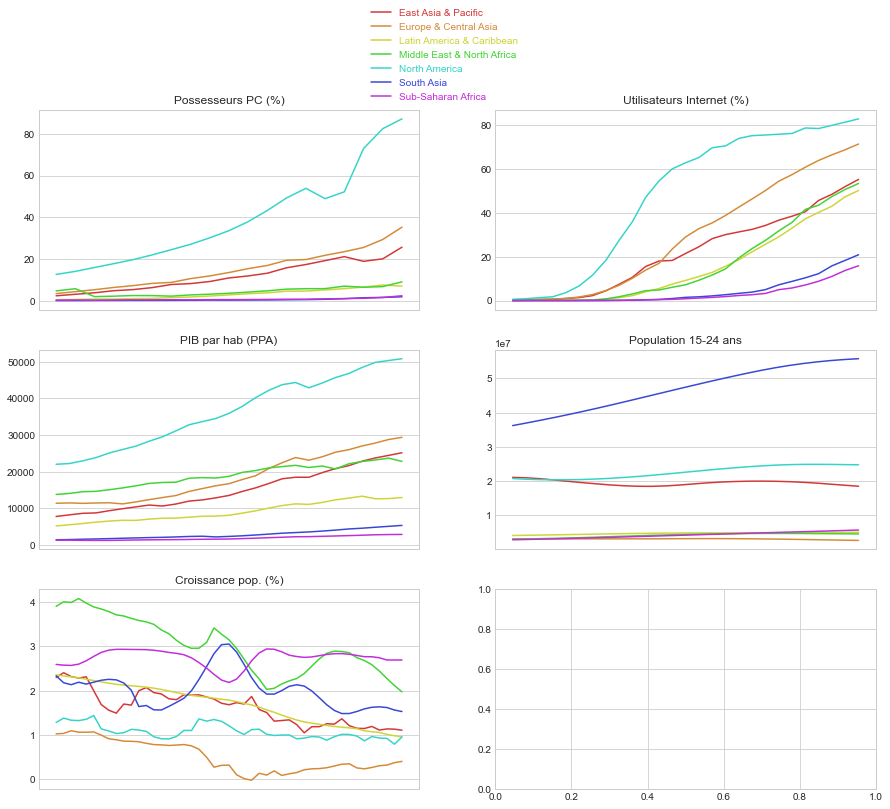

In [24]:
indicator_analysis_data = indicator_analysis_base_data.copy(deep=True)

# Calculating means
indicator_analysis_data = (indicator_analysis_data
                           .drop(columns=["Country Code"], errors="ignore")
                           .groupby(["Region", "Indicator Code"])
                           .mean()).reset_index().drop(columns=["index"])

colors = ["#d43737", "#d48b37", "#cfd437", "#42d435", "#35d4c9", "#3848d6", "#c22ed9"]
legend = {}

# Preparing the plot
x_ticks = []
x_ticks_labels = []
for column_name in indicator_analysis_data.columns:
    if re.match('r/^\d{4}$/', column_name):
        x_ticks.append(int(year))
        if year.endswith('0'):
            x_ticks_labels.append(str(year))
        else:
            x_ticks_labels.append("")
        
indicators = indicator_analysis_data["Indicator Code"].unique()
fig10, axes = plt.subplots(nrows=math.ceil(len(indicators)/2), ncols=2, figsize=(15,5*len(indicators)/2))
i = 0
for indicator in indicators:
    subdata = indicator_analysis_data[indicator_analysis_data["Indicator Code"] == indicator]\
                .dropna(how="any", axis=1)\
                .drop(columns=["Indicator Code"])\
                .set_index("Region")
    row_number = 0
    for row in subdata.iterrows():
        axes[math.floor(i/2), i%2].title.set_text(indicators_names[indicator])
        axes[math.floor(i/2), i%2].set_xticks(x_ticks)
        axes[math.floor(i/2), i%2].set_xticklabels(x_ticks_labels)
        axes[math.floor(i/2), i%2].plot(subdata.columns, subdata.iloc[row_number].values, color=colors[row_number])    
        
        # Storing the association serie/color for the legend
        legend[subdata.index[row_number]] = colors[row_number]
        row_number += 1
    i+=1

    
    
fig10.legend(legend.keys(), labelcolor=legend.values(), loc="upper center")


<a name="scoring"></a>
## H - Scoring des pays
La stratégie de scoring est la suivante : 
* On divise chaque valeur **par le maximum de sa colonne** de façon à avoir des valeurs entre 0 et 1.
* On va ensuite calculer la **somme pondérée** des colonnes pour avoir le score du pays.

Concernant les pondérations : 
* Dans un premier temps on applique une **pondération similaire** à tous les indicateurs,
* Ensuite on fera **varier les pondération** afin de voir si le classement change de manière significative.



In [25]:
def calculate_scores(coefficients, plot=False, score_name=None, return_index=False):
    """ Plot a bar chart with the scores calculated using the given coefficients
    
    Parameters:
    coefficient (dict): dictionnary of column_name: coefficient
    
    Returns:
    DataFrame: the scores sorted by DESC order or the list of sorted index
    
    """
    
    # We work on a copy of the data 
    scoring_data = final_indicators_values.copy(deep=True)
    score_column_name = "Score"

    # Dividing all columns by its max value to have [0;1] values
    scoring_data.iloc[:,:-1] = scoring_data.iloc[:,:-1].apply(lambda x: x / x.max())
    
    # For each row of the dataframe, we calculate the score
    for country_code, row in scoring_data.iterrows():
        score = 0
        for column, coef in coefficients.items():
            score += row[column] * coef
        scoring_data.at[country_code, score_column_name] = score

   
    # Dividing by the reference country score to easily get the highest potential countries
    ref_score = scoring_data.loc[REF_COUNTRY_CODE][score_column_name]
    scoring_data[score_column_name] = scoring_data[score_column_name] / ref_score

     # Sorting the results by score desc    
    scoring_data = scoring_data.sort_values(score_column_name, ascending=False)
    subset = scoring_data[score_column_name].to_frame()
    
    # Renaming the score column if asked
    if score_name != None:
        subset = subset.rename(columns={score_column_name: score_name})
        score_column_name = score_name

    # Returning the result and plotting the result if asked
    if plot:
        plt.xticks(rotation = 90)
        plt.bar(scoring_data["Country Name"], subset[score_column_name], color="goldenrod", edgecolor="#333333")

    if return_index:
        subset = subset.astype("string")
        for country_code, row in subset.iterrows():
            subset.at[country_code, score_column_name] = country_code
        subset = subset.reset_index().drop(columns=["Country Code"])
        
    return subset

<a name="reference-ranking"></a>
### Classement des pays avec des coefficients égaux (référence)

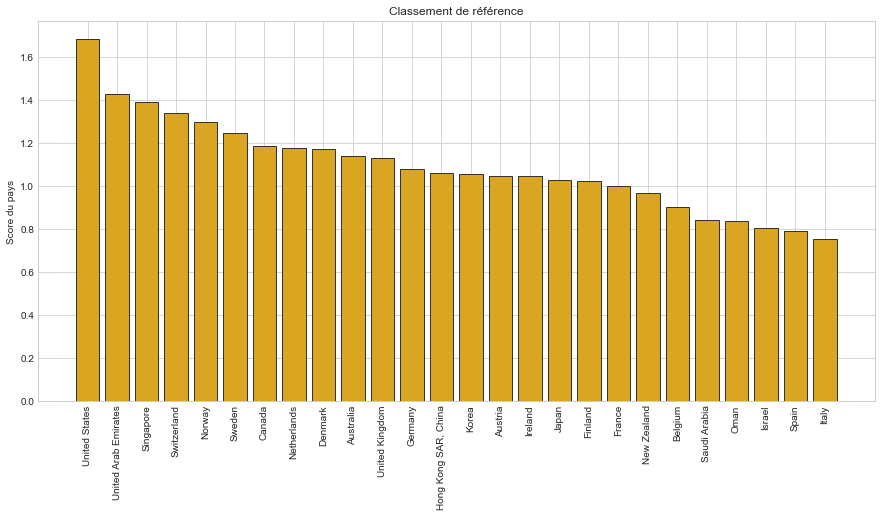

In [26]:
fig8 = plt.figure(figsize=(15,7))
plt.title("Classement de référence")
plt.ylabel("Score du pays")

scores = calculate_scores({
    'Utilisateurs Internet (%)': 1,
    'PIB par hab (PPA)': 1,
    'Population 15-24 ans': 1,
    'Croissance pop. (%)': 1,
    'Possesseurs PC (%)': 1
}, plot=True)

<a name="borda"></a>
### Impact de la modification des pondérations - Méthode Borda
On va maintenant regarder si notre classement est sensible ou non à une modification des pondérations.
Pour cela on va utiliser la méthode **Borda** : 
* On va appliquer un coefficient de 3 à un indicateur, 2 à un autre, et 1 à tous les indicateurs restants
* Pour 5 indicateurs, on va ainsi obtenir 20 classements différents de nos pays
* On applique alors la méthode Borda en considérant qu'on veut le classement des 10 meilleurs pays

Ainsi, pour chaque classement, le premier pays recevra 10 points, le second 9 points, etc... A partir du 11e, ils reçoivent tous 0 points.

En sommant, pour chaque pays, ses points obtenus à chaque classement, on obtiendra un classement global.

In [27]:
# Step 1 : we generate all possible indicator/weight possibilities
indicators = [
    'Utilisateurs Internet (%)',
    'PIB par hab (PPA)',
    'Population 15-24 ans',
    'Croissance pop. (%)',
    'Possesseurs PC (%)'
]
weights = [3,2]

all_coefficients = []
for combination in itertools.permutations(indicators, len(weights)):
    new_coefficients = {}
    for index, indicator in enumerate(indicators):
        if indicator in combination:
            new_coefficients[indicator] = weights[combination.index(indicator)]
        else: 
            new_coefficients[indicator] = 1
    all_coefficients.append(new_coefficients)
    
print("Les " + str(len(all_coefficients)) + " cas possibles ont été générés")

j=0
for coefficients in all_coefficients:
    print("\n")
    print("Classement #" + str(j) + " : ")
    for indic, coef in coefficients.items():
        if coef > 1:
            print(str(indic) + " : " + str(coef))
    
    j += 1

Les 20 cas possibles ont été générés


Classement #0 : 
Utilisateurs Internet (%) : 3
PIB par hab (PPA) : 2


Classement #1 : 
Utilisateurs Internet (%) : 3
Population 15-24 ans : 2


Classement #2 : 
Utilisateurs Internet (%) : 3
Croissance pop. (%) : 2


Classement #3 : 
Utilisateurs Internet (%) : 3
Possesseurs PC (%) : 2


Classement #4 : 
Utilisateurs Internet (%) : 2
PIB par hab (PPA) : 3


Classement #5 : 
PIB par hab (PPA) : 3
Population 15-24 ans : 2


Classement #6 : 
PIB par hab (PPA) : 3
Croissance pop. (%) : 2


Classement #7 : 
PIB par hab (PPA) : 3
Possesseurs PC (%) : 2


Classement #8 : 
Utilisateurs Internet (%) : 2
Population 15-24 ans : 3


Classement #9 : 
PIB par hab (PPA) : 2
Population 15-24 ans : 3


Classement #10 : 
Population 15-24 ans : 3
Croissance pop. (%) : 2


Classement #11 : 
Population 15-24 ans : 3
Possesseurs PC (%) : 2


Classement #12 : 
Utilisateurs Internet (%) : 2
Croissance pop. (%) : 3


Classement #13 : 
PIB par hab (PPA) : 2
Croissance pop

In [28]:
# Step 2 : we generate all rakings
reference_coefficients = {
    'Utilisateurs Internet (%)': 1,
    'PIB par hab (PPA)': 1,
    'Population 15-24 ans': 1,
    'Croissance pop. (%)': 1,
    'Possesseurs PC (%)': 1
}

# We initialize a dataframe with all the coefficients to weight 1 
rankings = calculate_scores(reference_coefficients, score_name="Reference score", return_index=True)
top_10 = rankings["Reference score"].head(15).tolist()

for index, coefficient_case in enumerate(all_coefficients):
    weighted_scores = calculate_scores(coefficient_case, 
                                       score_name="CASE_" + str(index), 
                                       return_index=True)
    rankings = rankings.merge(weighted_scores, left_index=True, right_index=True)


# Coloring the dataframe to highlight the top 10 of the reference ranking and see the differences
rankings_colors = rankings.copy(deep=True)
rankings_colors = rankings_colors.isin(top_10)

def color_cells(value):
    if value == True:
        return 'text-align:center; width: 120px; background-color:#ffefe0; font-weight:bold; border:1px solid #fac28e;'
    else:
        return 'text-align:center; width: 120px; '

print("Les couleurs nous permettent de visualiser que le Top 10 de référence ne changent pas beaucoup")
rankings.style.apply(lambda x: rankings_colors.applymap(color_cells), axis=None)

Les couleurs nous permettent de visualiser que le Top 10 de référence ne changent pas beaucoup


Maintenant on part de ce tableau et on calcule le score de chaque pays : 

In [29]:
scores = {}
MAX_SCORE = 15

for index, row in enumerate(rankings.values.tolist()):
    for country in row:
        if not country in scores:
            scores[country] = 0
        score = MAX_SCORE - index
        scores[country] += max([score, 0])

# Sorting by score DESC
scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))

scores

{'USA': 307,
 'SGP': 268,
 'CHE': 260,
 'NOR': 242,
 'ARE': 238,
 'SWE': 220,
 'CAN': 173,
 'NLD': 155,
 'DNK': 143,
 'AUS': 123,
 'GBR': 115,
 'DEU': 64,
 'KOR': 41,
 'HKG': 39,
 'OMN': 33,
 'IRL': 29,
 'JPN': 27,
 'AUT': 18,
 'FIN': 11,
 'SAU': 9,
 'FRA': 5,
 'NZL': 0,
 'BEL': 0,
 'ESP': 0,
 'ITA': 0,
 'ISR': 0}

<a name="conclusion"></a>
## I - Conclusion
Il ne nous reste plus qu'à tracer les scores sur un graphiques : 

<BarContainer object of 21 artists>

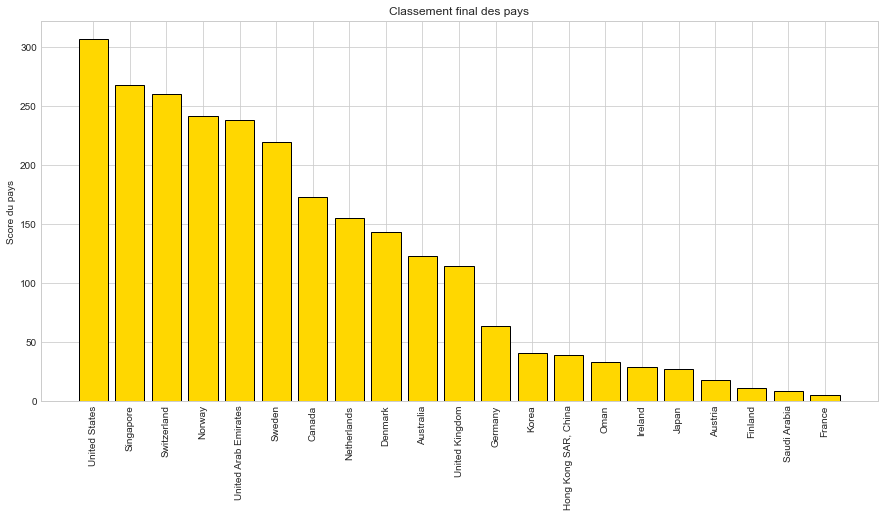

In [30]:
# Renaming the country code by the country name and keeping only scores > 0
named_scores = {}
for country_code, score in scores.items():
    if score > 0:
        country_name = countries[countries["Country Code"] == country_code]["Short Name"].values[0]
        named_scores[country_name] = score

fig9 = plt.figure(figsize=(15,7))
plt.xticks(rotation = 90)
plt.title("Classement final des pays")
plt.ylabel("Score du pays")
plt.bar(named_scores.keys(), named_scores.values(), color="gold", edgecolor="black")